# Week 4 - Partial Least Squares Regression

We will reimplement and then explore some of the properties of [Cosgrove et al](http://pubs.rsc.org/en/Content/ArticleLanding/2010/MB/b926287c).

In [1]:
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt

data = sio.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principal components do you need for each to explain 90% of the Y variance? Discuss your findings.

Hint: Be sure you are normalizing each dataset as needed for the analysis.

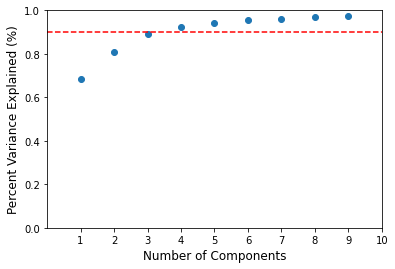

In [2]:
import pandas as pd

components = np.arange(1, 10, 1)
scores = []

for i in components:
    pls = PLSRegression(n_components=i)
    pls.fit(X, Y[:, -1])
    scores.append(pls.score(X, Y[:, -1]))

plt.scatter(components, scores)
plt.ylabel('Percent Variance Explained (%)', fontsize=12)
plt.xlabel('Number of Components', fontsize=12)
plt.plot([0, 100], [0.9, 0.9], '--r')
plt.ylim([0, 1])
plt.xlim([0, 10])
plt.xticks(np.arange(1, 11, 1));

We find that we need 4 components to explain 90% of the variance in Y. As we might expect, we find that the first components explain the largest portions of variance and that the variance explained asymptotically approaches 1--each added component appears to explain less of the remaining variance than its predeccesor.

#### (2) How would you expect the percent of X variance explained to compare between PLSR and PCA? Why?

I would expect PCA to have a higher percentage of X variance explained than PLSR. PCA chooses components that minimize variance with X whereas PLSR chooses components to minimize the covariance between X and Y. As such, PCA will necessarily develop components that best explain the variance in X whereas PLSR will not.

#### (3) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

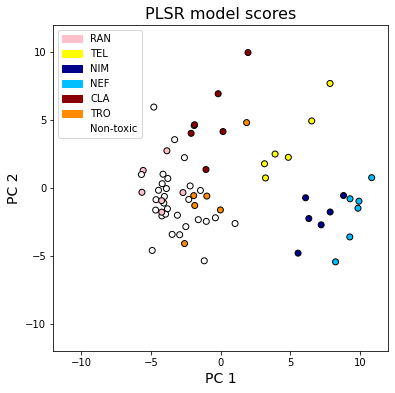

In [3]:
import matplotlib.patches as mpatches

pls = PLSRegression(n_components=4)
pls.fit(X, Y[:, -1])
scores = pls.x_scores_
pcs = scores[:, :2]

plt.figure(figsize=[6, 6])
plt.ylim([-12, 12])
plt.xlim([-12, 12])
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('PLSR model scores', fontsize=16)

toxic_colors = {
    'RAN': 'pink',
    'TEL': 'yellow',
    'NIM': 'darkblue',
    'NEF': 'deepskyblue',
    'CLA': 'darkred',
    'TRO': 'darkorange',
    'Non-toxic': 'white'
}

colors = []
for i in range(len(scores)):
    drug = np.argwhere(drugs[i] == 1)
    drug = drugList[drug][0][0]
    
    color = 'white'
    if drug in toxic_colors.keys():
        color = toxic_colors[drug]
    
    colors.append(color)
    
toxic = list(toxic_colors.keys())
patches = [mpatches.Patch(color=toxic_colors[i], label=i) for i in toxic]

plt.scatter(pcs[:, 0], pcs[:, 1], color=colors,
           edgecolors='k')

plt.legend(handles=patches)
plt.show()

#### (4) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

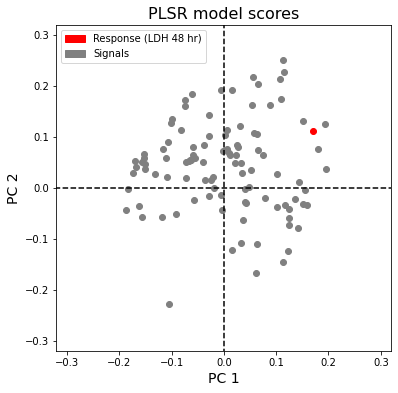

In [4]:
loadings = pls.x_weights_ 
response = pls.y_weights_

pcs = loadings[:, :2]

plt.figure(figsize=[6, 6])
plt.ylim([-.32, .32])
plt.xlim([-.32, .32])
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('PLSR model scores', fontsize=16)

patches = [mpatches.Patch(color='red', label='Response (LDH 48 hr)'),
           mpatches.Patch(color='grey', label='Signals')]
plt.legend(handles=patches)

plt.plot([-10, 10], [0, 0], '--k')
plt.plot([0, 0], [-10, 10], '--k')
plt.scatter(pcs[:, 0], pcs[:, 1], color='grey')
plt.scatter(response[0, 0], response[0, 1], color='red')
plt.show()

In the above plot, the red point depicts our response (Y) while the grey points represent the values of our signals across the first two principal components.

We find that this reponse is positively associated with both of these prinicipal components; it shows, however, a stronger positive association with PC 1 than PC 2. As such, increasing elements positively associated with both PC 1 and PC 2 (or decreasing an element negatively associated with both components) should increase the response. Additionally, increasing an element with a PC 1 as or more positive than its PC 2 is negative will also increase the response as the response is more strongly associated with PC 1 than it is PC 2.

Additionally, we find that the vast majority of our signals have a positive association with at least one of the two components; there are few signals negatively associated with both components. As such, there are few signals which oppose response along both components.

#### (5) Add the variance of the loadings to your loadings plot (this can be shown as error bars). How does the variance of component one compare to that of component two? Would you expect a trend in the general variance versus component number?

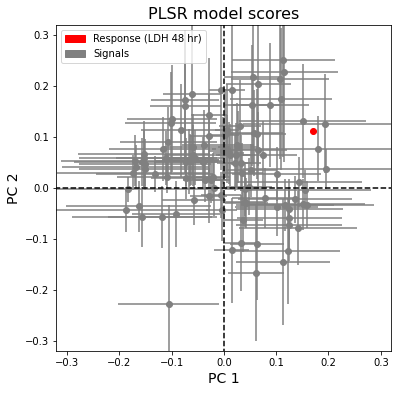

In [5]:
from sklearn.utils import resample
import pandas as pd

pcs = loadings[:, :2]

plt.figure(figsize=[6, 6])
plt.ylim([-.32, .32])
plt.xlim([-.32, .32])
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('PLSR model scores', fontsize=16)

patches = [mpatches.Patch(color='red', label='Response (LDH 48 hr)'),
           mpatches.Patch(color='grey', label='Signals')]
plt.legend(handles=patches)

plt.plot([-10, 10], [0, 0], '--k')
plt.plot([0, 0], [-10, 10], '--k')
plt.scatter(pcs[:, 0], pcs[:, 1], color='grey')
plt.scatter(response[0, 0], response[0, 1], color='red')

trials = 1000
vars_1 = pd.DataFrame(index=range(trials), columns=range(102))
vars_2 = pd.DataFrame(index=range(trials), columns=range(102))
loadboot = np.empty((trials, pcs.shape[0], 2))

for i in range(trials):
    X_boot, Y_boot = resample(X, Y[:, -1])
    pls = PLSRegression(n_components=2)
    pls.fit(X_boot, Y_boot)
    loadboot[i, :, :] = pls.x_weights_[:, :2]
    
vars = np.std(loadboot, axis=0)
plt.errorbar(pcs[:, 0], pcs[:, 1], xerr=vars[:, 0], yerr=vars[:, 1], linestyle='', color='grey')
plt.show()

We should generally expect more variance on higher component numbers, because they are built with the residuals from the lower ones. There is a lot of variance in the model, indicating that a replicated dataset might end up with very different loadings.

#### (6) Recreate a 4-principal component model using PLSR with just the final 4 phosphoprotein model. Plot predicted v. observed LDH for this model. Report the model fitness ($R^2$). Define here how you are calculating $R^2$.

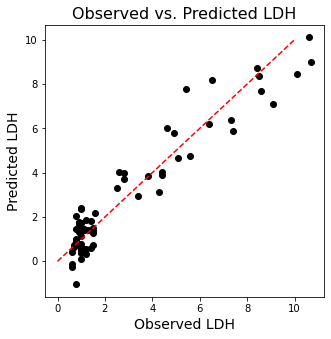

Model Fitness (R-squared): 0.9031360902736856


In [6]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict

final_4 = ['p-MEK1', 'p-ERK1/2', 'p-Akt', 'p-p70 S6K', 'p-p38', 'p-HSP27']
to_keep = []

for i, phospho in enumerate(phosphoproteins):
    if any([final in phospho for final in final_4]):
        to_keep.append(i)
 
trimmed_X = X[:, to_keep]

pls = PLSRegression(n_components=4)
pls.fit(trimmed_X, Y[:, -1])
predicted = pls.predict(trimmed_X)
score = r2_score(Y[:, -1], predicted)

plt.figure(figsize=[5, 5])
plt.ylabel('Predicted LDH', fontsize=14)
plt.xlabel('Observed LDH', fontsize=14)
plt.title('Observed vs. Predicted LDH', fontsize=16)

plt.plot([0, 10], [0, 10], '--r')
plt.scatter(Y[:, -1], predicted, color='k')
plt.show()

print(f'Model Fitness (R-squared): {score}')

For the above, we calculate R-squared by first fitting our model with our X and Y matrices. We then use the model to predict Y from X and use sklearn's r2score to derive the R-squared score for the predicted and measured values of Y.

#### (7) Cosgrove *et al* discusses their method for model validation using leave-one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

In [7]:
predicted = cross_val_predict(pls, trimmed_X, Y[:, -1], cv=LeaveOneOut())

print(f'Model Fitness (R-squared): {r2_score(Y[:, -1], predicted)}')

Model Fitness (R-squared): 0.8418832347463815


As noted above, our R-squared value is noticably less than that of Question 6 indicating that our model fitness is less than we estimated earlier. This result is a testament to the importance of cross-validation; our earlier method for testing model fitness provided the model with knowledge of the testing set by including the testing data in the fitting process. As such, we likely over-estimated model fitness as our model had prior knowledge of the testing set. In using cross-validation, we prevent this by using folds to split testing and training sets, thereby preventing the model from learning the testing data prematurely.

#### (8) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

In [8]:
groups = [i % 6 + 1 for i in range(66)]

cv=LeaveOneGroupOut().split(trimmed_X, Y[:, -1], groups)
predicted = cross_val_predict(pls, trimmed_X, Y[:, -1], cv=cv)

print(f'Model Fitness (R-squared): {r2_score(Y[:, -1], predicted)}')

Model Fitness (R-squared): 0.8221684924334306


From the above, we can see that this leave-one-cytokine-out cross-validation (LOCOCV) slightly the estimated predictive ability of the model.

Which is most appropriate comes down to which observations you expect to be independent, and/or what sort of task do you expect of the model. If you expect that the model should have learned a pattern independent of a given cytokine, then you might want to check that it works for entirely new cytokines. In this case, the LOGO approach would be more appropriate.